# Part B: NLPs

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from collections import Counter

### 23:
I took the data from here: https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview
It's a data which I already made a personal project on, you can review it on github: https://github.com/aviad1486/Comment-Toxicity/tree/main
* This problem will be a multi-label classification - I'll predict toxic comments which can be useful for making the Internet a better place

In [3]:
df_NLP = pd.read_csv("toxic_comments.csv")
df_NLP

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \r\n\r\nThat...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \r\n\r\nUmm, theres no actual article ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


### Preprocess

using **Tokenization**

In [4]:
df_NLP.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

This Imbalance is expected in this multi-label data due to many comments have multiple labels.

so oversampling will be useless because when I upsample each label independently, the total count of toxic rows ends up duplicated more often than others.

because of that my prediction metric will be **F1-score** and in 24 I'll talk about after reviewing the model's results

Label distribution:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


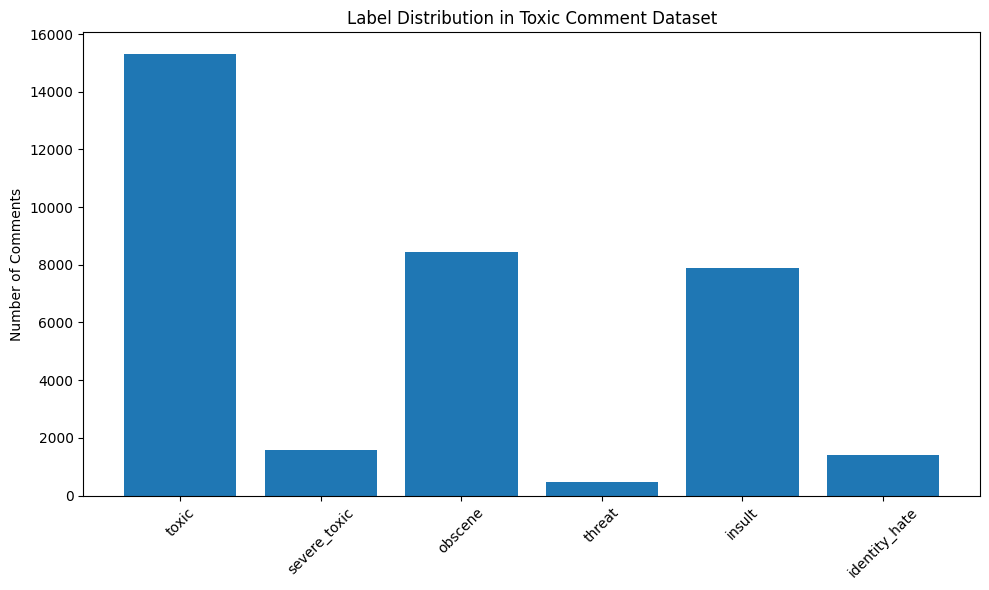

In [5]:
label_columns = df_NLP.columns[2:]

label_counts = df_NLP[label_columns].sum()

print("Label distribution:")
print(label_counts)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values)
plt.title('Label Distribution in Toxic Comment Dataset')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Tokenization**

In [ ]:
X = df_NLP['comment_text'] # remove ID col which is useless for the model
y = df_NLP[df_NLP.columns[2:]].values 

MAX_FEATURES = 200000 # number of words in the vocab
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [7]:
vectorizer.adapt(X.values) # Learning the vocabulary from the training data
vectorized_text = vectorizer(X.values) # Converts all comments into numerical token sequences.

Tensorflow data pipeline:

In [9]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y)) # create a dataset: [vectorized_text][y values]
dataset = dataset.cache() # stores the data in cache to speed up the training
dataset = dataset.shuffle(160000) # shuffles the samples to prevent the model learning patterns in the order of data
dataset = dataset.batch(16) # encapsulate 16 samples for one group/batch for faster training
dataset = dataset.prefetch(8) # ensures training never waits for data by loading the next batches in advance

In [10]:
train = dataset.take(int(len(dataset)*.7)) # 70% training
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2)) # 20% for validation 
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1)) # 10# for test

Obvious question is: Why do we need vectorization if we have embedding layer? vectorizer give a unique id (int) for each word and not a vector so we need the embedding layer to give this a vector ID for each word.

here's my sources:
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

### Don't train the model because it gonna take few hours, please scroll down and run the cell which load my trained model

In [11]:
model = Sequential()

# Create the embedding layer - converts words into vectors
model.add(Embedding(MAX_FEATURES+1, output_dim = 32))

# Bidirectional LSTM Layer captures relationships from both past & future words
model.add(Bidirectional(LSTM(32, activation='tanh')))

# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# Final layer - Multi-label classification
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='BinaryCrossentropy', optimizer='Adam',metrics=[tf.keras.metrics.F1Score()])
model.build(input_shape=(None, 1800))  # Batch size is flexible (None), sequence length is 1800

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1800, 32)       │     6,400,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,491,686 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train, validation_data=val, epochs=10)

Epoch 1/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1779s 254ms/step - f1_score: 0.0309 - loss: 0.0831 - val_f1_score: 0.0295 - val_loss: 0.0506
Epoch 2/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1612s 231ms/step - f1_score: 0.0294 - loss: 0.0459 - val_f1_score: 0.0301 - val_loss: 0.0414
Epoch 3/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1537s 220ms/step - f1_score: 0.0292 - loss: 0.0409 - val_f1_score: 0.0286 - val_loss: 0.0356
Epoch 4/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1527s 219ms/step - f1_score: 0.0309 - loss: 0.0357 - val_f1_score: 0.0297 - val_loss: 0.0325
Epoch 5/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1514s 217ms/step - f1_score: 0.0325 - loss: 0.0320 - val_f1_score: 0.0286 - val_loss: 0.0275
Epoch 6/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1488s 213ms/step - f1_score: 0.0316 - loss: 0.0287 - val_f1_score: 0.0295 - val_loss: 0.0255
Epoch 7/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1485s 213ms/step - f1_score: 0.0372 - loss: 0.0264 - val_f1_score: 0.0419 - val_loss: 0.0236
Epoch 8/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1494s 214ms/s

<Figure size 800x500 with 0 Axes>

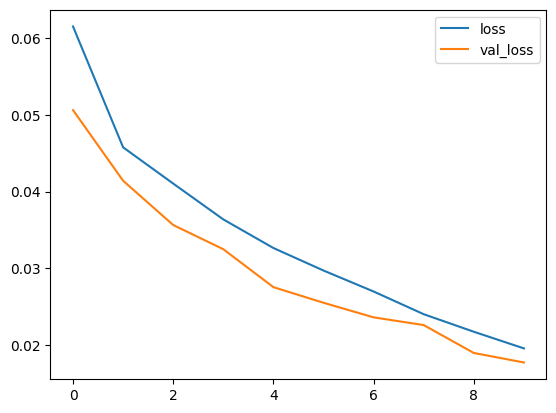

In [13]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

### 24:
* Introducing word cloud and the most common words
* Making predictions on the train set and test set with printing classification report
* Explaining in words my text analysis the descriptive data and the model's results and their meaning in relation to the text

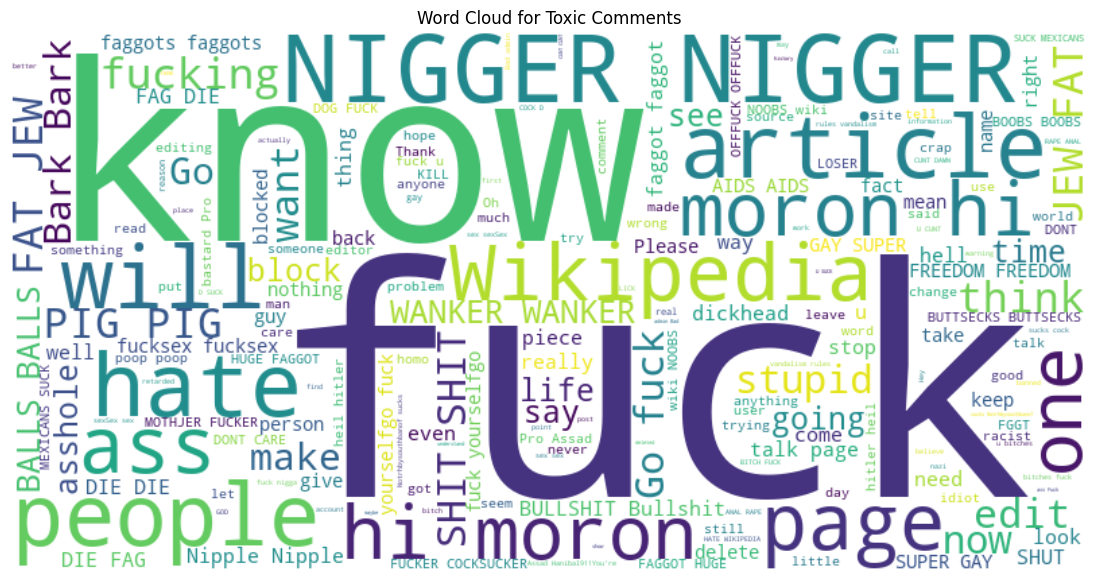

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter only toxic comments
toxic_text = df_NLP[df_NLP['toxic'] == 1]['comment_text']
toxic_text_string = " ".join(toxic_text)

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(toxic_text_string)

# Plot the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Toxic Comments')
plt.show()


In [18]:
model.save('toxicity.h5.keras')

In [ ]:
model = tf.keras.models.load_model('toxicity.h5.keras')

In [33]:
from sklearn.metrics import classification_report
import numpy as np

# Helper: get predictions from dataset
def get_predictions(dataset):
    y_true_all = []
    y_pred_all = []

    for batch in dataset.as_numpy_iterator():
        X_batch, y_batch = batch
        y_pred = model.predict(X_batch)

        y_true_all.append(y_batch)
        y_pred_all.append(y_pred)

    # Stack all batches together
    y_true_all = np.vstack(y_true_all)
    y_pred_all = np.vstack(y_pred_all)

    # Convert probs to binary predictions (multi-label)
    y_pred_all_bin = (y_pred_all >= 0.5).astype(int)

    return y_true_all, y_pred_all_bin

In [34]:
y_train_true, y_train_pred = get_predictions(train)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

In [35]:
y_test_true, y_test_pred = get_predictions(test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━

In [36]:
print("=== Classification Report for Train Set ===")
print(classification_report(y_train_true, y_train_pred, target_names=label_columns))

=== Classification Report for Train Set ===
               precision    recall  f1-score   support

        toxic       0.95      0.97      0.96     10736
 severe_toxic       0.77      0.45      0.57      1147
      obscene       0.94      0.96      0.95      5954
       threat       0.92      0.03      0.07       323
       insult       0.92      0.90      0.91      5531
identity_hate       0.77      0.72      0.75      1017

    micro avg       0.93      0.90      0.91     24708
    macro avg       0.88      0.67      0.70     24708
 weighted avg       0.92      0.90      0.91     24708
  samples avg       0.09      0.09      0.09     24708



c:\Users\aviad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aviad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aviad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [37]:
print("=== Classification Report for Test Set ===")
print(classification_report(y_test_true, y_test_pred, target_names=label_columns))

=== Classification Report for Test Set ===
               precision    recall  f1-score   support

        toxic       0.94      0.96      0.95      1507
 severe_toxic       0.74      0.42      0.53       170
      obscene       0.94      0.95      0.95       829
       threat       0.80      0.07      0.13        56
       insult       0.92      0.90      0.91       764
identity_hate       0.68      0.70      0.69       136

    micro avg       0.92      0.89      0.91      3462
    macro avg       0.84      0.67      0.69      3462
 weighted avg       0.92      0.89      0.90      3462
  samples avg       0.09      0.09      0.09      3462



c:\Users\aviad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aviad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aviad\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

We analyzed toxic comments using a Bidirectional LSTM model, which is ideal for understanding the context of sentences. Since comments often include phrases, Bidirectional LSTM allows the model to read the text from both directions — forward and backward — and remember important words using its internal memory, which is critical for interpreting tone and intent.

To prepare the data, we used a TextVectorization layer to tokenize and pad the raw comments into fixed-length integer sequences. This is necessary because models can’t process raw text. Then, an Embedding layer converted each word into a dense vector that captures its meaning and relationship to other words — important because words like "idiot", "kill", and "dumb" often appear in toxic comments, and understanding their context helps improve classification.

Although the dataset is imbalanced, we chose not to manually oversample the rare classes because in this classification task, those labels often overlap with more common ones like "toxic". Oversampling would have caused also upsample the major class and won't be useful, so to overcome it I evaluated the model using the F1-score, which balances precision (how many predicted positives were correct) and recall (how many actual positives were found). This metric is more meaningful than accuracy in imbalanced multi-label tasks, where the goal is not just to be correct, but to catch all relevant toxic behaviors without raising too many false alarms.

After 10 training epochs, the model performed well, especially for common labels like "toxic", "obscene", and "insult".  
Overall, the model is effective, and results can improve further with more training epochs